# FOR.AI challendge walk-through

### Imports, global variables used for plots

In [4]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("/Users/gorjanradevski/PycharmProjects/forai_challenge/src")
plt.rcParams["figure.figsize"] = (15,8)
from basic_utils.constants import prune_k

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Unit and weight pruning

This section goes through the results obtained when the network is unit or weight pruned while trained with or without weight decay. In other words, a full network is trained for N epochs, and the network that achieves the highest accuracy on the validation after a certain epoch set is saved. 

- Weight pruning is done when the k% smallest weights for each layer of the network, based on their magnitude, are set to 0 or pruned away. The NN by default is robust against small pruning percentages because not all learned weights are important for making the prediction. In addition, the weights that have the smallest magnitude are the least important.
- Unit pruning is done when the k% smallest columns for each weight matrix of the network, based on their Euclidean norm, are set to 0 or pruned away. Because weight pruning prunes entire neurons (columns of the weight matricies), it is expected that the accuracy with degrade more rapidly compared to unit pruning.


## Effects of weight decay

Because neural networks have a strong tendency towards having specific weights specializing on certain features and thus having large magnitude in order to catch oscillations in the data, weight decay is employed to penalize the NN for that. The outcome is a NN that has weights with balanced responsibilities (small magnitudes), which in turn makes the NN more robust against pruning as well as overfitting.

- The plots using green and yellow color showcase the results obtained with the same NN architecture trained with L2 weight decay of 0.01.

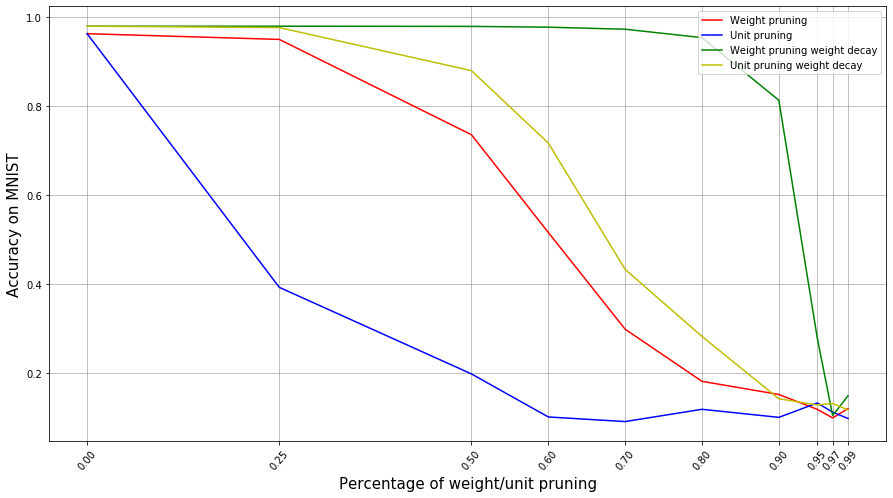

In [6]:
accuracy_weight_prune = [0.9632762738853503, 0.950437898089172, 0.7360668789808917, 0.5163216560509554,
                      0.29866640127388533, 0.18142914012738853, 0.15187101910828024, 0.11843152866242038,
                      0.09912420382165606, 0.12022292993630573]

accuracy_unit_prune = [0.9632762738853503, 0.39281449044585987, 0.19814888535031847, 0.10131369426751592,
                        0.09096337579617834, 0.11853105095541401, 0.10041799363057324, 0.13276273885350318,
                        0.11216162420382166, 0.09783041401273886]

accuracy_weight_prune_wd = [0.9800955414012739, 0.9800955414012739, 0.9796974522292994,
            0.977906050955414, 0.973328025477707, 0.9544187898089171,
           0.81359474522293, 0.2786624203821656, 0.1044984076433121, 0.14898487261146498]

accuracy_unit_prune_wd = [0.9800955414012739, 0.9770103503184714, 0.8801751592356688, 0.7174562101910829,
                        0.43322054140127386, 0.28244426751592355, 0.1422173566878981, 0.1282842356687898,
                        0.1317675159235669, 0.11713773885350319]

plt.xlabel("Percentage of weight/unit pruning", fontsize=15)
plt.ylabel("Accuracy on MNIST", fontsize=15)
plt.plot(prune_k, accuracy_weight_prune, "r", label="Weight pruning")
plt.plot(prune_k, accuracy_unit_prune, "b", label="Unit pruning")
plt.plot(prune_k, accuracy_weight_prune_wd, "g", label="Weight pruning weight decay")
plt.plot(prune_k, accuracy_unit_prune_wd, "y", label="Unit pruning weight decay")
plt.xticks(prune_k)
plt.xticks(rotation=50)
plt.grid()
plt.legend(loc='upper right')
plt.show()

## Thoughts on benefiting from the induced sparsity

Because the pruning introduced sparsity on the weights, we can benefit from that. For example, when a weight matrix is weight pruned (whole columns are set to be 0), the multiplications between the input rows and those columns are redundant because the output will always be zero.

Tensorflow gives us the option to set a flag when doing matrix multiplication whether the first, the second, or both tensors are sparse which reduces the execution time. Below is an example of that.

In [111]:
from timeit import default_timer as timer
from datetime import timedelta
import tensorflow as tf

tf.reset_default_graph()
sparse = tf.placeholder_with_default(0, shape=None)
a = np.random.rand(1000,5000).astype(np.float32)
b = np.zeros((5000,5000), dtype=np.float32)
mul = tf.matmul(a, b, a_is_sparse=False, b_is_sparse=True if sparse is 1 else False)
with tf.Session() as sess:
    start = timer()
    sess.run(mul, feed_dict={sparse: 1})
    end = timer()
    print("Using dense-dense multiplication: ",timedelta(seconds=end-start))
    start = timer()
    sess.run(mul)
    end = timer()
    print("Using dense-sparse multiplication: ",timedelta(seconds=end-start))

Using dense-dense multiplication:  0:00:00.929578
Using dense-sparse multiplication:  0:00:00.718447
